# Model Training & Threshold Discovery
**Student Name:** Ali Cihan Ozdemir  
**Course:** CSCN8010 Practical Lab 1

## Objectives
1. Connect to Neon.tech PostgreSQL database.
2. Pull training data.
3. Perform Univariate Linear Regression on 8 axes.
4. Compute Residuals.
5. Determine Anomaly Thresholds (MinC, MaxC, T).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import json
import sys
import os

# Add src to path
sys.path.append('../src')
from db_connector import DatabaseConnector

## 1. Load Data from Database

In [2]:
connector = DatabaseConnector()
engine = connector.get_engine()

query = "SELECT * FROM training_data ORDER BY time ASC"
df = pd.read_sql(query, engine)
df.head()

,time,seconds_from_start,axis_1,axis_1_minmax,axis_1_std,axis_2,axis_2_minmax,axis_2_std,axis_3,axis_3_minmax,...,axis_5_std,axis_6,axis_6_minmax,axis_6_std,axis_7,axis_7_minmax,axis_7_std,axis_8,axis_8_minmax,axis_8_std
0,2022-10-17 12:18:23.660000+00:00,0.000,0.0,0.0,-0.335663,0.0,0.0,-0.525203,0.0,0.0,...,-0.454494,0.0,0.0,-0.330172,0.0,0.0,-0.401579,0.0,0.0,-0.241599
1,2022-10-17 12:18:25.472000+00:00,1.812,0.0,0.0,-0.335663,0.0,0.0,-0.525203,0.0,0.0,...,-0.454494,0.0,0.0,-0.330172,0.0,0.0,-0.401579,0.0,0.0,-0.241599
2,2022-10-17 12:18:27.348000+00:00,3.688,0.0,0.0,-0.335663,0.0,0.0,-0.525203,0.0,0.0,...,-0.454494,0.0,0.0,-0.330172,0.0,0.0,-0.401579,0.0,0.0,-0.241599
3,2022-10-17 12:18:29.222000+00:00,5.562,0.0,0.0,-0.335663,0.0,0.0,-0.525203,0.0,0.0,...,-0.454494,0.0,0.0,-0.330172,0.0,0.0,-0.401579,0.0,0.0,-0.241599
4,2022-10-17 12:18:31.117000+00:00,7.457,0.0,0.0,-0.335663,0.0,0.0,-0.525203,0.0,0.0,...,-0.454494,0.0,0.0,-0.330172,0.0,0.0,-0.401579,0.0,0.0,-0.241599


## 2. Univariate Linear Regression
We will fit a model for each axis: $Axis value = slope * time + intercept$

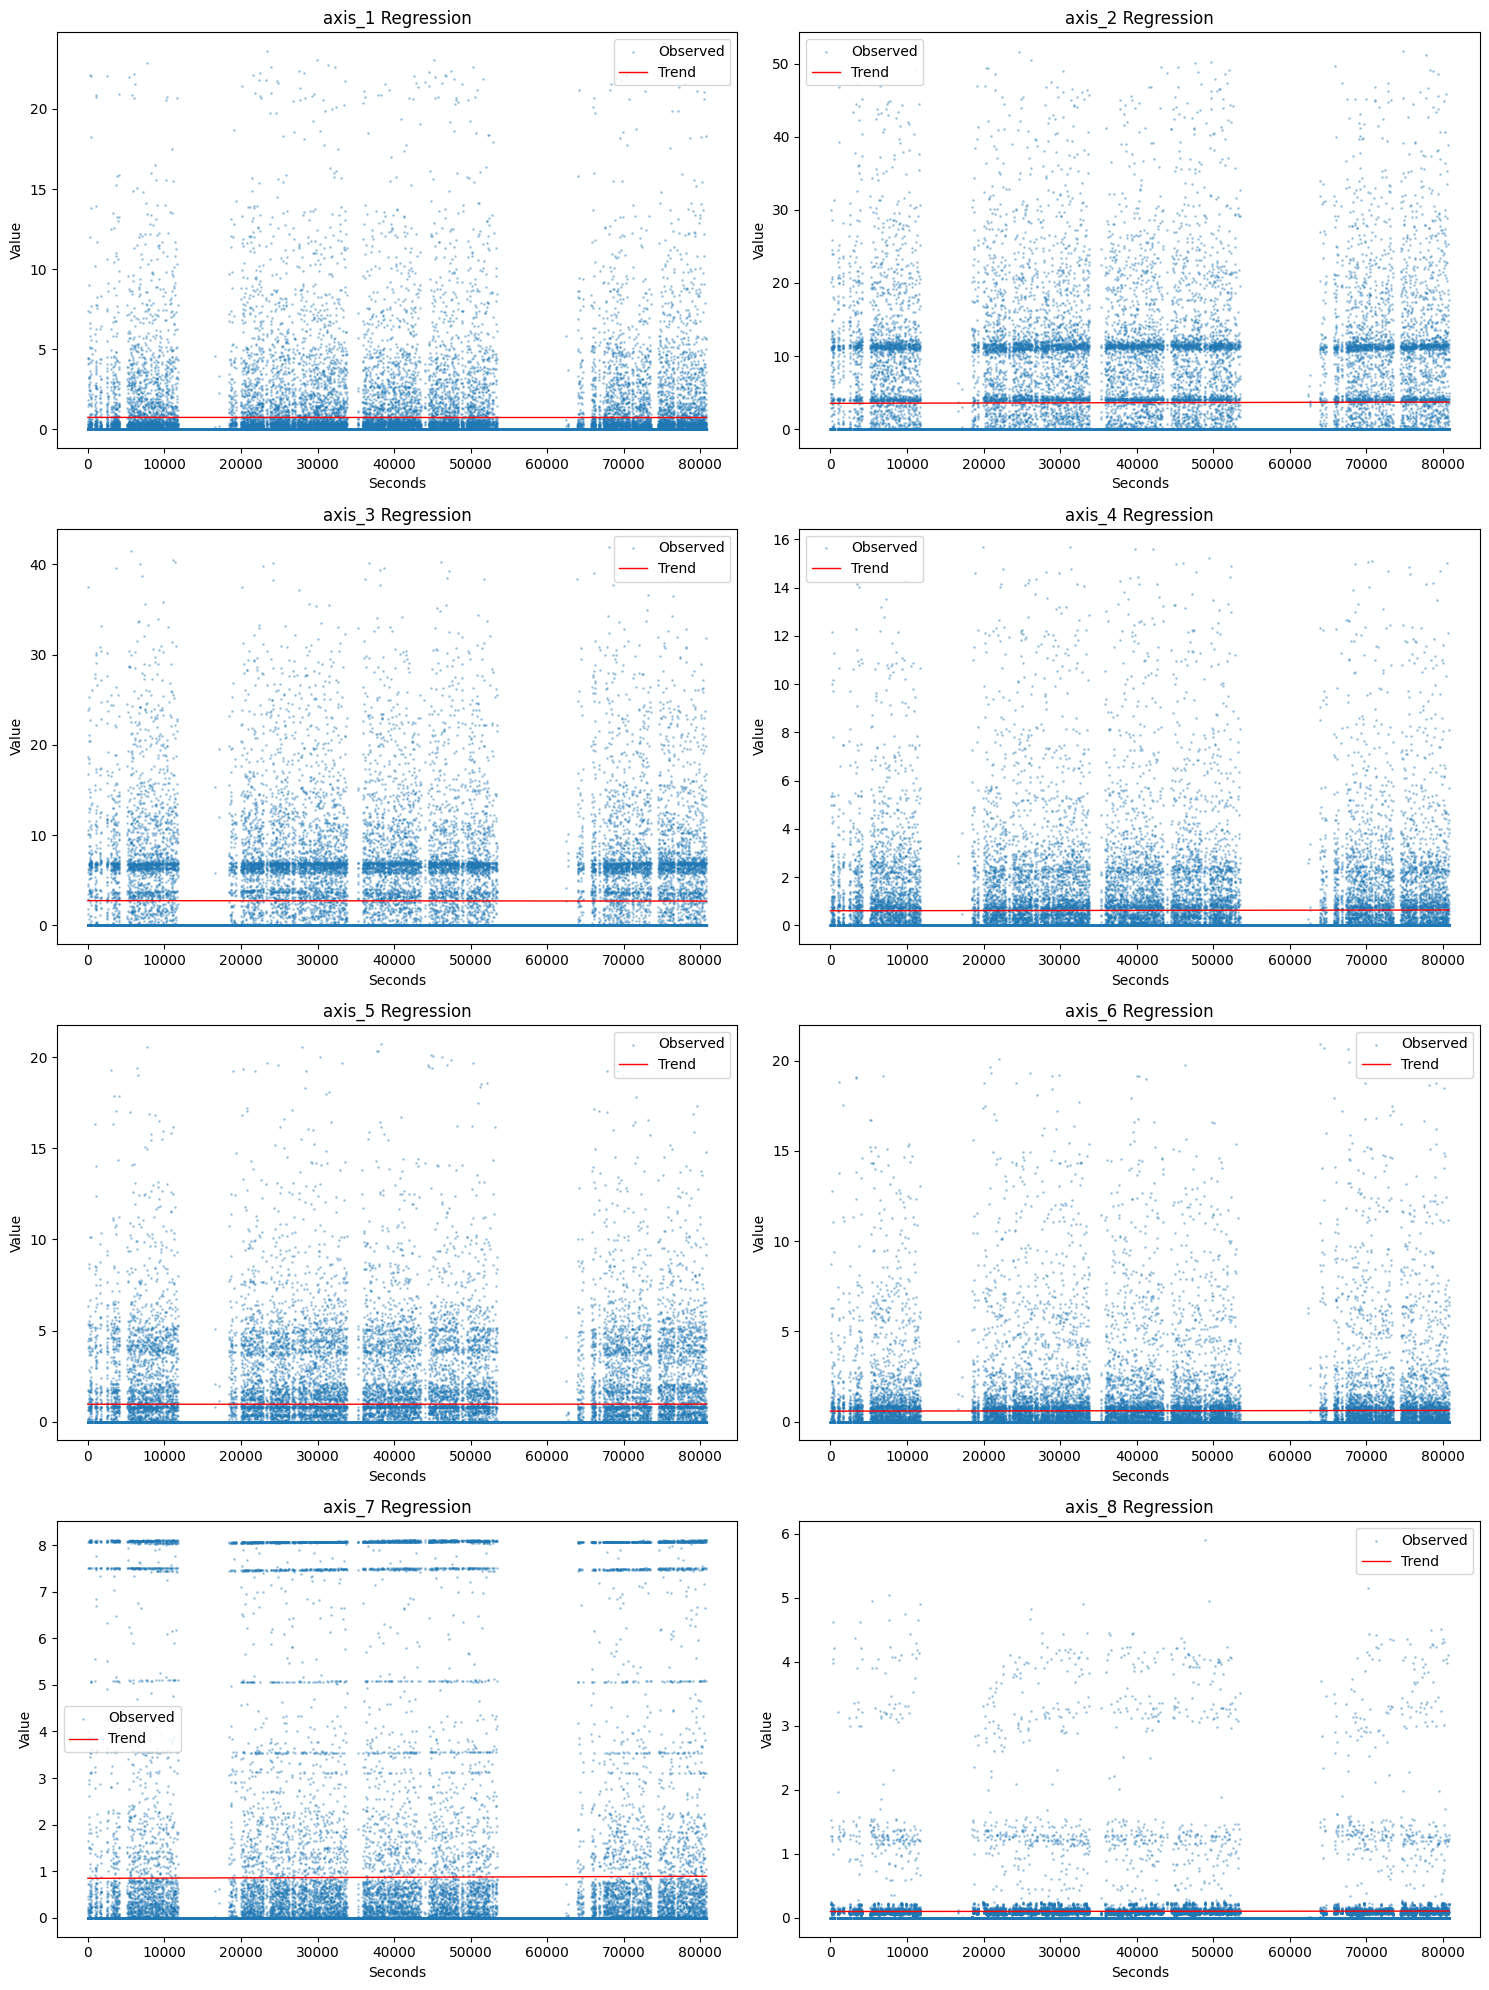

In [3]:
axes = [f'axis_{i}' for i in range(1, 9)]
models = {}
residuals = {}

X = df[['seconds_from_start']].values

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.flatten()

for i, axis in enumerate(axes):
    y = df[axis].values
    
    # Fit Model
    reg = LinearRegression()
    reg.fit(X, y)
    
    # Predictions
    y_pred = reg.predict(X)
    
    # Store Metadata
    models[axis] = {
        'slope': reg.coef_[0],
        'intercept': reg.intercept_
    }
    
    # Store Residuals
    res = y - y_pred
    residuals[axis] = res
    
    # Plot
    axs[i].scatter(X, y, alpha=0.3, s=1, label='Observed')
    axs[i].plot(X, y_pred, color='red', linewidth=1, label='Trend')
    axs[i].set_title(f'{axis} Regression')
    axs[i].set_xlabel('Seconds')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()

## 3. Threshold Discovery
We calculate residuals and determine MinC and MaxC based on statistical bounds (e.g., 3 sigma).

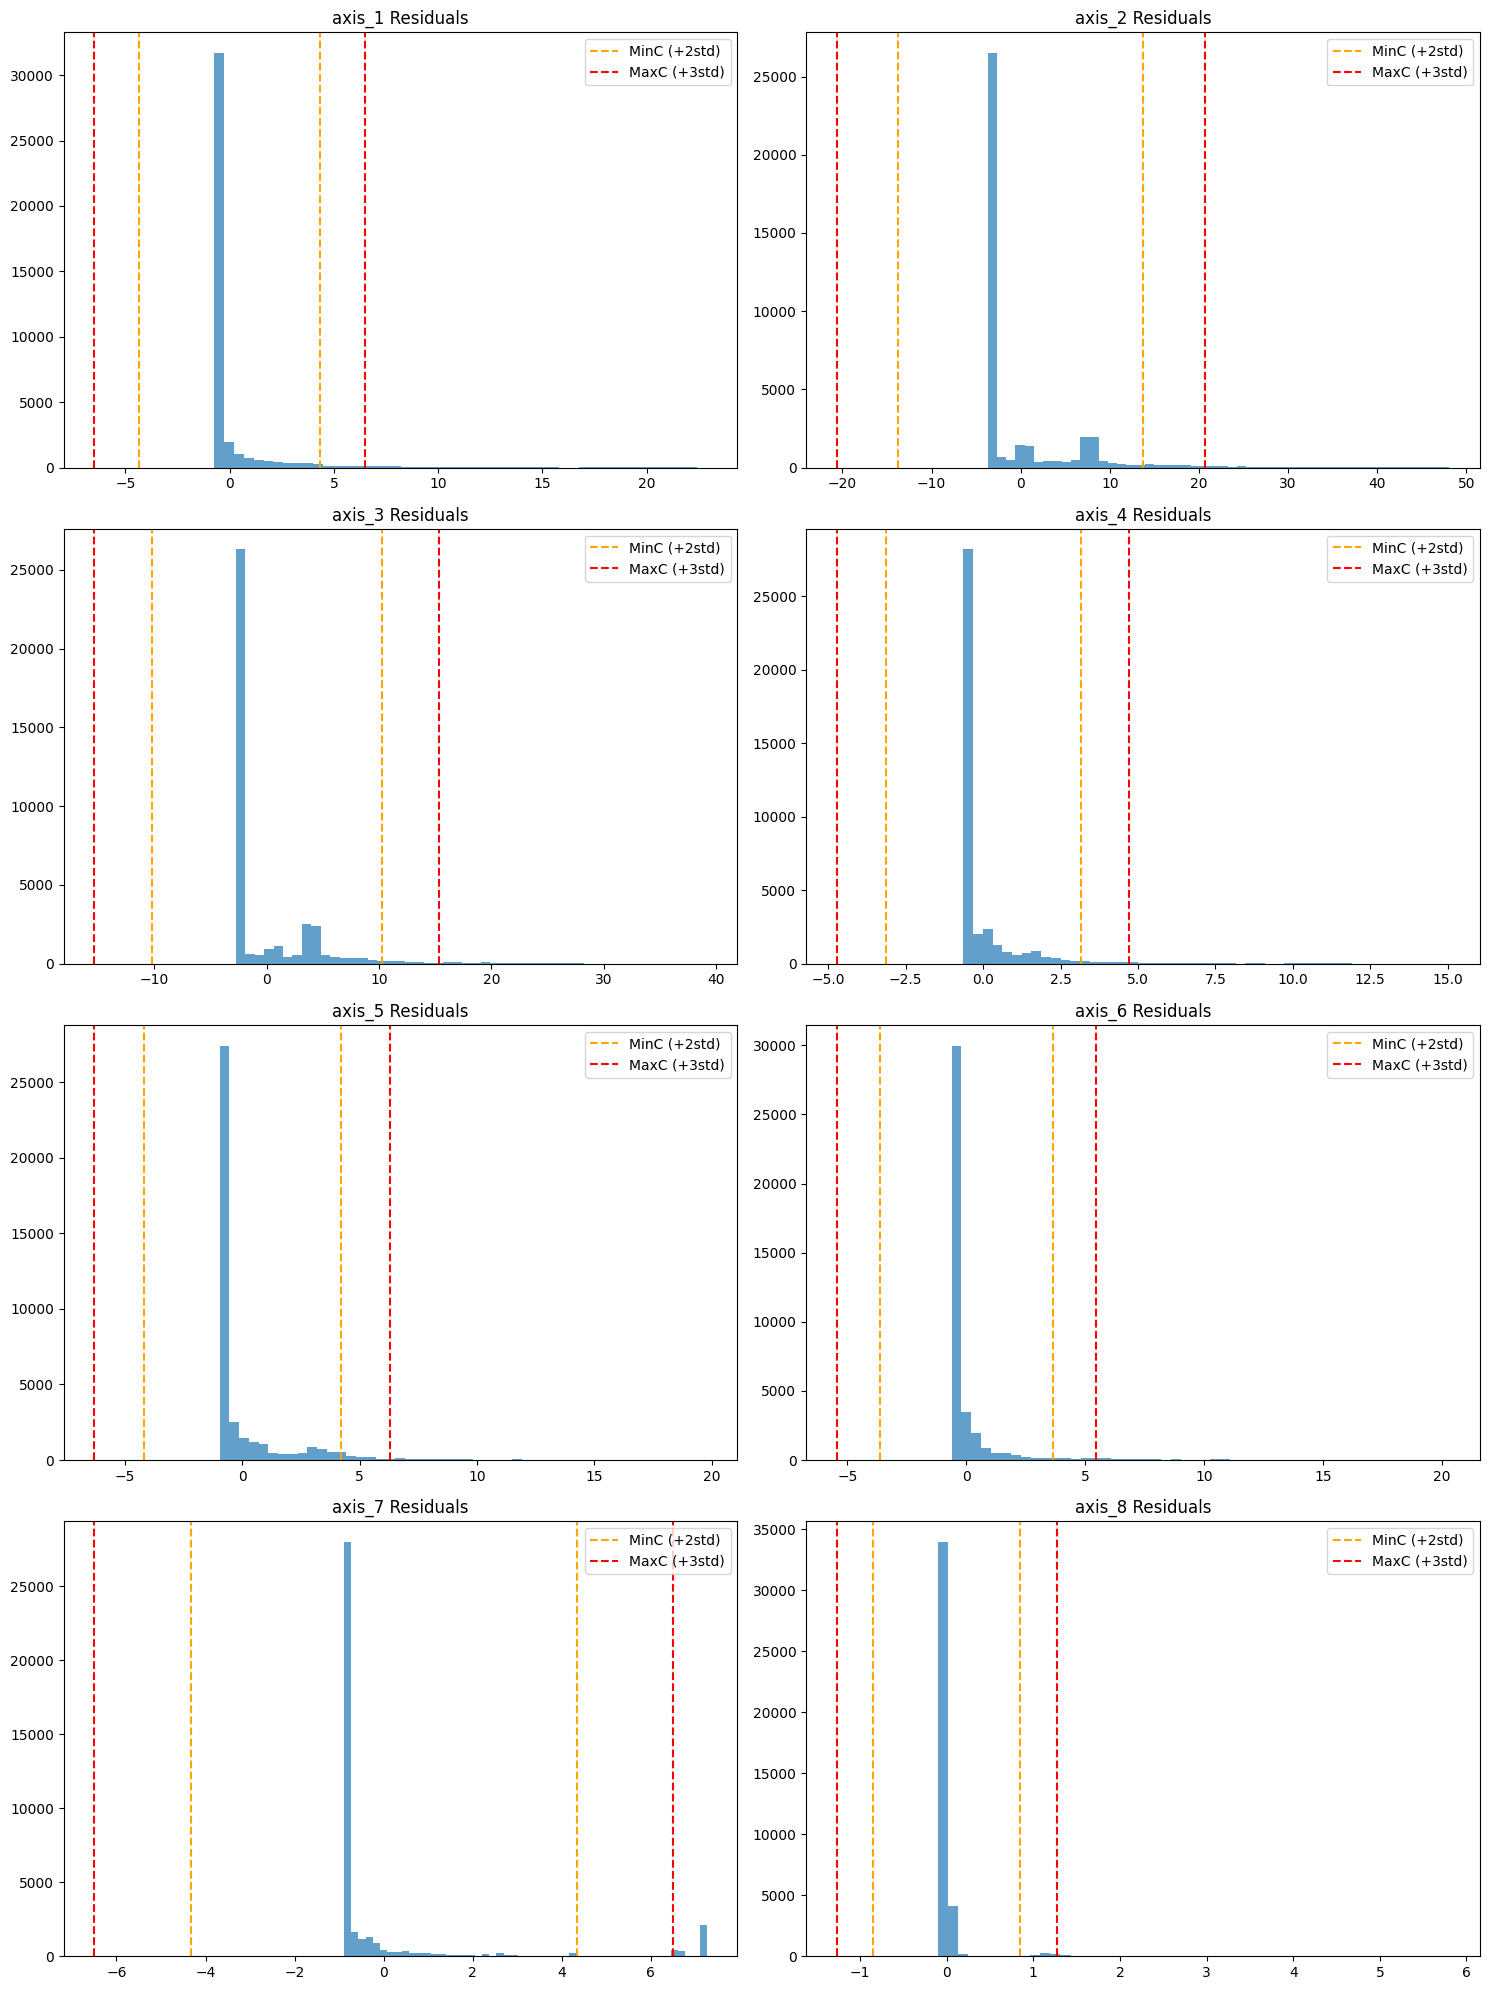

In [4]:
thresholds = {}

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.flatten()

for i, axis in enumerate(axes):
    res = residuals[axis]
    
    mean_res = np.mean(res)
    std_res = np.std(res)
    
    # Define Thresholds
    # MinC: Alert Threshold (e.g., 2 sigma)
    # MaxC: Error Threshold (e.g., 3 sigma)
    # Note: These apply to the absolute residual magnitude or signed?
    # Assuming symmetric bounds for now.
    
    min_c = 3 * std_res  # Using 3 sigma as suggested alert level or stricter?
    # Prompt says: MinC (e.g., 2s), MaxC (e.g., 3s).
    min_c = 2 * std_res
    max_c = 3 * std_res
    
    thresholds[axis] = {
        'min_c': min_c,
        'max_c': max_c,
        'std': std_res,
        'mean': mean_res
    }
    
    # Plot Hist
    axs[i].hist(res, bins=50, alpha=0.7)
    axs[i].axvline(mean_res + min_c, color='orange', linestyle='--', label='MinC (+2std)')
    axs[i].axvline(mean_res + max_c, color='red', linestyle='--', label='MaxC (+3std)')
    axs[i].axvline(mean_res - min_c, color='orange', linestyle='--')
    axs[i].axvline(mean_res - max_c, color='red', linestyle='--')
    axs[i].set_title(f'{axis} Residuals')
    axs[i].legend()

plt.tight_layout()
plt.show()

## 4. Save Metadata
Saving model coefficients and thresholds to JSON.

In [5]:
metadata = {
    'models': models,
    'thresholds': thresholds,
    'global_config': {
        'T_seconds': 5  # Initial proposal, subject to tuning
    }
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved to ../models/model_metadata.json")

Metadata saved to ../models/model_metadata.json
